# ¿Cómo trabajar datos sismológicos en cualquier computador?

### Bienvenidas y bienvenidos.

Este taller consta de 3 modulos:

1.   Introducción a python
2.   Descargar datos sismologicos usando Obspy
3.   Analizar sismogramas

Ante cualquier duda o consulta dirigirse a catalina.morales@ucsc.cl

Este taller fue creado por Catalina Morales-Yáñez, para que las y los asistentes pueden comprender y trabajar con datos sismologicos. Si necesita usarlo para algún otro fin por favor consulte previamente.

# Sismogramas

En las sección anterior aprendimos como descargar sismogramas. En este capitulo aprenderemos como trabajar con ellos, comencemos instalando cartopy y obspy e montando nuestro drive

In [ ]:
# Primero instalamos Obspy
!pip install cartopy
!pip install obspy

In [ ]:
#Luego creamos una carpeta en nuestro drive para guardar los datos

import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

folder = "/content/drive/My Drive/Borrar_test"

# Create a folder in the root directory
!mkdir -p "/content/drive/My Drive/Borrar_test"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importamos lo modulos necesarios
from obspy.core.event import read_events # Obspy event class que permite leer eventos de un catalogo
from obspy.clients.fdsn import Client # obspy class que nos permite escoger el "cliente" de donde descargaremos los datos
from obspy import UTCDateTime # obspy class para leer el tiempo
import matplotlib.pyplot as plt # Modulo para graficar
import pandas as pd #Modulo para el manejo de datos
import numpy as np #Modulo con funciones matemáticas
import obspy #Obspy general
import scipy #Modulo matematico

In [ ]:
# Continuaremos trabajando con el sismograma del terremoto del Maule

client=Client("IRIS")


st = client.get_waveforms(
    network="IU",
    station="PMSA",
    location="*",
    channel="BHZ",
    starttime=obspy.UTCDateTime("2010-02-27T06:35:00"),
    endtime=obspy.UTCDateTime("2010-02-27T07:00:00"),
    attach_response=True,
)

print(st)

# Sacamos la traza
tr = st[0]

1 Trace(s) in Stream:
IU.PMSA.00.BHZ | 2010-02-27T06:35:00.035058Z - 2010-02-27T06:59:59.985058Z | 20.0 Hz, 30000 samples


# Remover la respuesta instrumental
Los sismogramas nos muestran la amplitud de la forma de onda, sin embargo esta por si sola no tiene unidades físicas. Para poder analizar estos datos es necesario realizar el traspaso a unidades como desplazamiento, velocidad o aceleración. Para esto removemos la respuesta instrumental.

Notaron que al usar get_events, usamos ``` attach_response=True ``` eso quiere decir que al descargar los datos, descargamos además la respuesta instrumental, entonces podemos usar obspy para removerla.



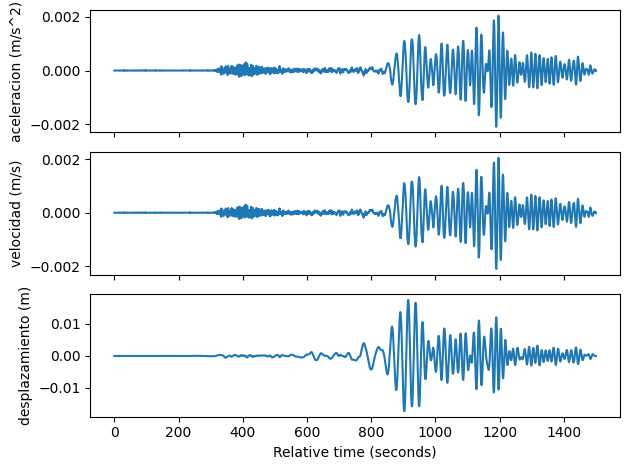

In [ ]:
# Prefiltro, esto en general es necesario para remover la respuesta
filter_frequencies = 0.01, 0.015, 15, 20

#Removamos la respuesta instrumental para obtener aceleración

tr_acc = tr.copy()
tr_acc.remove_response(output="ACC", pre_filt=filter_frequencies)

#Ahora para obtener velocidad

tr_vel = tr.copy()
tr_vel.remove_response(output="ACC", pre_filt=filter_frequencies)

#Finalmente para obtener velocidad

tr_desp = tr.copy()
tr_desp.remove_response(output="DISP", pre_filt=filter_frequencies)

t = tr.times()

#Grafiquemos

fig, ax = plt.subplots(3, sharex=True)

ax[0].plot(t,tr_acc)
ax[0].set_ylabel("aceleracion (m/s^2)")
ax[1].plot(t,tr_vel)
ax[1].set_ylabel("velocidad (m/s)")
ax[2].plot(t,tr_desp)
ax[2].set_ylabel("desplazamiento (m)")

ax[-1].set_xlabel("Relative time (seconds)")
plt.tight_layout()
plt.show()

# Filtros

Los filtros disponibles corresponden a

*   bandpass

*   bandstop

*   lowpass

*   highpass



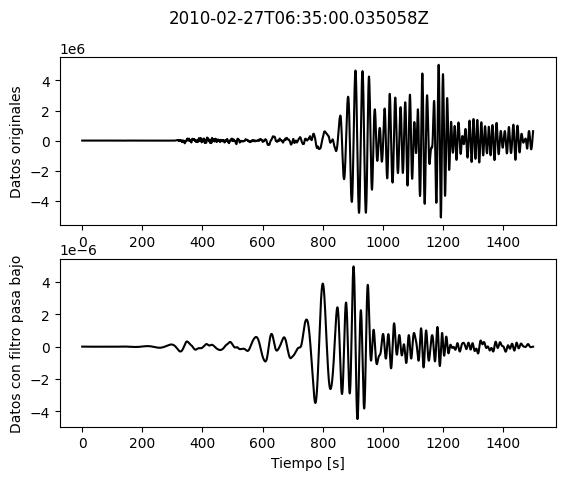

In [ ]:


# Copiamos la traza y la filtramos con un filtro pasa bajo
tr_filt = tr_vel.copy()
tr_filt.filter('lowpass', freq=.01, corners=2, zerophase=True)

# Grafiquemos ambas trazas
plt.figure()
t = np.arange(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.delta)
plt.subplot(211)
plt.plot(t, tr.data, 'k')
plt.ylabel('Datos originales')
plt.subplot(212)
plt.plot(t, tr_filt.data, 'k')
plt.ylabel('Datos con filtro pasa bajo')
plt.xlabel('Tiempo [s]')
plt.suptitle(tr.stats.starttime)
plt.show()

# Decimar
Decimar es lo que se realiza para disminuir las muestras de un sismograma. En obspy para decimar por ejemplo de 200Hz a 50Hz, necesitamos escribir el factor por el cual debemos dividir 200 para que llegue a 50, entonces el factor de decimación será 4.

In [ ]:
tr.stats

               network: IU
               station: PMSA
              location: 00
               channel: BHZ
             starttime: 2010-02-27T06:35:00.035058Z
               endtime: 2010-02-27T06:59:59.985058Z
         sampling_rate: 20.0
                 delta: 0.05
                  npts: 30000
                 calib: 1.0
_fdsnws_dataselect_url: http://service.iris.edu/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'M', 'number_of_records': 168, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 86016})
            processing: ['ObsPy 1.4.0: trim(endtime=UTCDateTime(2010, 2, 27, 6, 59, 59, 985058)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2010, 2, 27, 6, 34, 59, 985058))']
              response: Channel Response
	From m/s (Velocity in Meters Per Second) to counts (Digital Counts)
	Overall Sensitivity: 1.03812e+09 defined at 0.050 Hz
	6 stages:
		Stage 1: PolesZerosRe

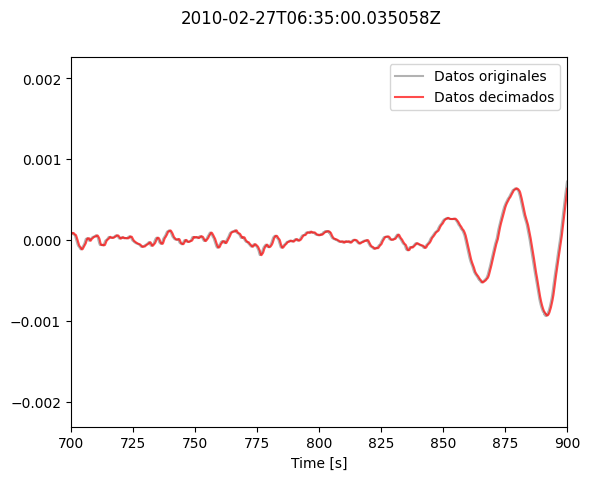

In [ ]:
#Podemos observar que nuestra traza tiene 20 muestras por segundo.
# Entonces decimemos por un factor de 4

tr_dec = tr_vel.copy()
tr_dec.decimate(factor=4, strict_length=False)

# Grafiquemos la traza original con la decimada

t     = np.arange(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.delta)
#Noten que al cambiar la cantidad de muestras el vector tiempo debe ser diferente
t_dec = np.arange(0, tr_dec.stats.npts / tr_dec.stats.sampling_rate,
                  tr_dec.stats.delta)

plt.plot(t, tr_vel.data, 'k', label='Datos originales', alpha=0.3)
plt.plot(t_dec, tr_dec.data, 'r', label='Datos decimados', alpha=0.7)
plt.xlabel('Time [s]')
plt.xlim(700, 900)
plt.suptitle(tr.stats.starttime)
plt.legend()
plt.show()



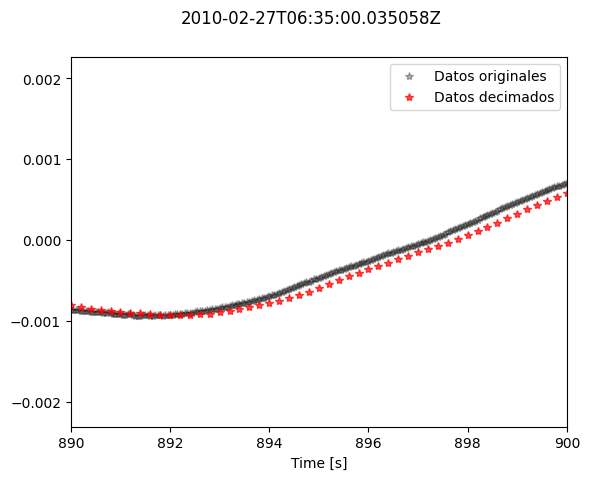

In [ ]:
#Como se puede observar no hay mucha diferencia entre las trazas
#para mayor detalle graficaremos con puntos y nos acercaremos
plt.plot(t, tr_vel.data, '*k', label='Datos originales', alpha=0.3)
plt.plot(t_dec, tr_dec.data, '*r', label='Datos decimados', alpha=0.7)
plt.xlabel('Time [s]')
plt.xlim(890, 900)
plt.suptitle(tr.stats.starttime)
plt.legend()
plt.show()

# Envolvente de un sismograma

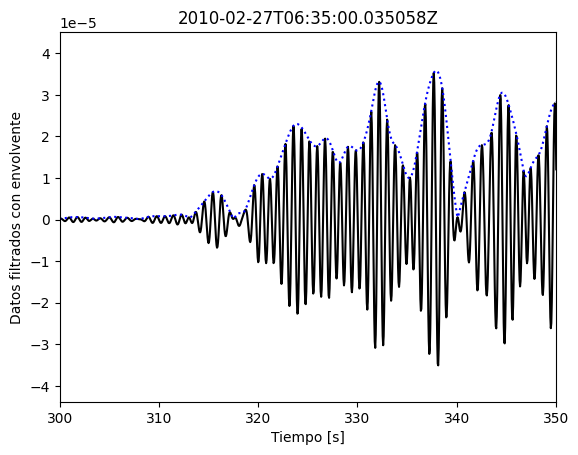

In [ ]:
# Filtramos
tr_filt2 = tr_vel.copy()
tr_filt2.filter('bandpass', freqmin=1, freqmax=1.5, corners=2, zerophase=True)

# Envolvente del sismograma
data_envolvente = obspy.signal.filter.envelope(tr_filt2.data)

# The plotting, plain matplotlib
t = np.arange(0, tr_vel.stats.npts / tr_vel.stats.sampling_rate, tr_vel.stats.delta)
plt.plot(t, tr_filt2.data, 'k')
plt.plot(t, data_envolvente, 'b:')
plt.title(st[0].stats.starttime)
plt.ylabel('Datos filtrados con envolvente')
plt.xlabel('Tiempo [s]')
plt.xlim(300,350)
plt.show()

# Análisis espectral

Otra herramienta útil para las sismologas es el análisis espectral. Este nos índica el contenido de frecuencias de los sismogramas. Para calcular el espectro de frecuencia de una señal generalmente usamos la transformada de Fourier. Para esto nos ayudaremos del modulo numpy

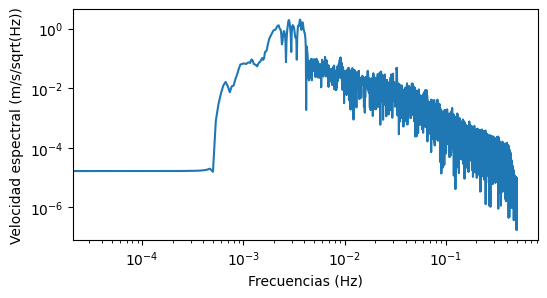

In [ ]:
#Primero calculamos la transformada de Fourier
espectro = np.fft.rfft(tr_vel.data)

# Definimos el vector de frecuencias
frecuencias = np.fft.rfftfreq(tr_vel.stats.npts)

# Graficamos
plt.figure(figsize=(6, 3))
plt.loglog(frecuencias, np.abs(espectro))
plt.xlabel("Frecuencias (Hz)")
plt.ylabel("Velocidad espectral (m/s/sqrt(Hz))")

plt.show()

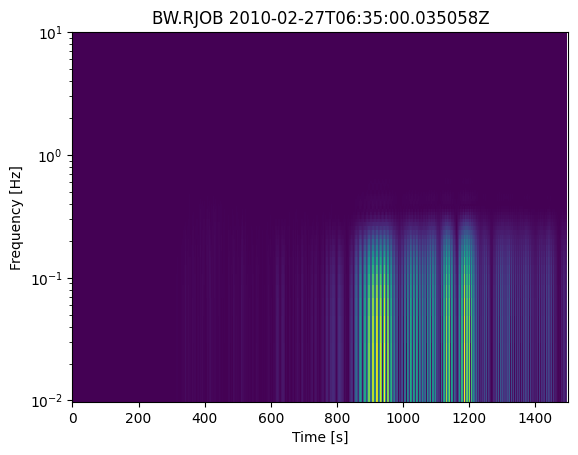

[None]

In [ ]:
#Ahora realicemos el espectograma de la señal usando obspy

st.spectrogram(log=True, title='BW.RJOB ' + str(st[0].stats.starttime))


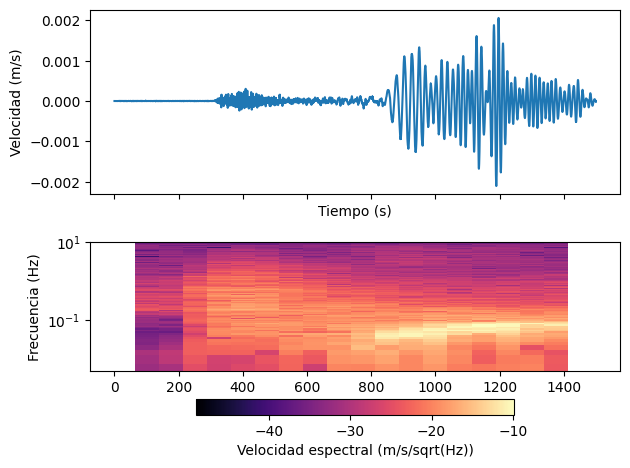

In [ ]:
# Ejemplo usando scipy
from scipy.signal import spectrogram

# Extraemos la forma de onda
waveform = tr_vel.data
times = tr_vel.times()

# Calculo del espectrograma
frequencies, spectrogram_times, psd = spectrogram(waveform, fs=tr.stats.sampling_rate, nperseg=4000, noverlap=2500)

# Un arreglo ya que la primera frecuencia esta ajustada a 0
frequencies[0] = frequencies[1]

# Figura
plt.figure(6)
plt.clf()
fig, axes = plt.subplots(nrows=2, num=6, sharex=True)

axes[0].plot(times, waveform)
axes[0].set_xlabel("Tiempo (s)")
axes[0].set_ylabel("Velocidad (m/s)")

mappable = axes[1].pcolormesh(spectrogram_times, frequencies, np.log(np.abs(psd)), rasterized=True, cmap="magma")
axes[1].set_xlabel("Tiempo (s)")
axes[1].set_ylabel("Frecuencia (Hz)")

colorbar = plt.colorbar(mappable, ax=axes[1], orientation="horizontal", shrink=0.6)
colorbar.set_label("Velocidad espectral (m/s/sqrt(Hz))")

axes[1].set_yscale("log")

# Do a crazy job with labels
plt.tight_layout()
# Show
plt.show()

# Desafío

¿Qué pasaría si decimamos y filtramos antes de